## Hypothesis Testing
#### Important: Make sure you have the following dataframe in the ram before executing the codes
##### (1) df_10ksp_filtered3 for the approach of BAG OF WORDS
##### (2) df_10ksp_filtered4 for the approach of TF-IDF
##### (3) df_10ksp_filtered5 for the approach of BERT

In [266]:
%store -r df_10ksp_filtered3
%store -r df_10ksp_filtered4
%store -r df_10ksp_filtered5

In [2]:
import pandas as pd
import numpy as np

In [14]:
#in case you need to call these variables by uploading:
#skip this if you already created these variables in jupyter notebook
df_10ksp_filtered3=pd.read_csv('filter3.csv')#if your local save is under other file name, please change
df_10ksp_filtered4=pd.read_csv('filtered4.csv')
df_10ksp_filtered5=pd.read_csv('finbert_df5.csv')

In [18]:
#volume data and control variables
vol_url='https://raw.githubusercontent.com/ethancn01/10ksentimentalanalysis/main/Vol_data.csv'
vol=pd.read_csv(vol_url)
vol.drop(vol.columns[-2], axis=1, inplace=True)
vol['abnormal_vol_mcd']=vol['d4']/vol['base_vol']
vol['abnormal_vol_mcd'].mean()

1.1499918794793276

In [49]:
#Abnormal return
ar_url='https://raw.githubusercontent.com/ethancn01/10ksentimentalanalysis/main/Abnormal_return.xlsx'
ar=pd.read_excel(ar_url)

In [50]:
ar.head(3)

,Unnamed: 0,ACCESSION NUMBER,CONFORMED SUBMISSION TYPE,CONFORMED PERIOD OF REPORT,FILED AS OF DATE,DATE AS OF CHANGE,COMPANY CONFORMED NAME,CENTRAL INDEX KEY,ticker (vlookup),FISCAL YEAR END,CAR(T0),CAR(T1),CAR(T3),CAR(T5),CAR(T10),CAR(T15),CAR(T20),CAR(T30),CAR(T60)
0,0,0000004904-00-000039,10-K405,19991231,20000324,Not found,AMERICAN ELECTRIC POWER COMPANY INC,4904,AEP,1231,0.012700,0.022754,-0.009894,-0.027305,-0.007303,0.023747,0.076834,0.135472,0.146637
1,1,0000037996-00-000019,10-K,19991231,20000316,Not found,FORD MOTOR CO,37996,F,1231,-0.081310,-0.066145,-0.076908,-0.125355,-0.083754,-0.030085,0.052572,0.066003,-0.034343
2,2,0000898430-00-003950,10-K,20000930,20001227,Not found,JACOBS ENGINEERING GROUP INC /DE/,52988,J,930,-0.015927,-0.037694,0.006655,0.068483,0.031468,0.122843,0.092758,0.089306,0.022812


In [ ]:
ar

## 1. BAG OF WORDS

In [8]:
df_10ksp_filtered3['neg_proportion']=df_10ksp_filtered3['Negative']/df_10ksp_filtered3['Total Word Count']

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


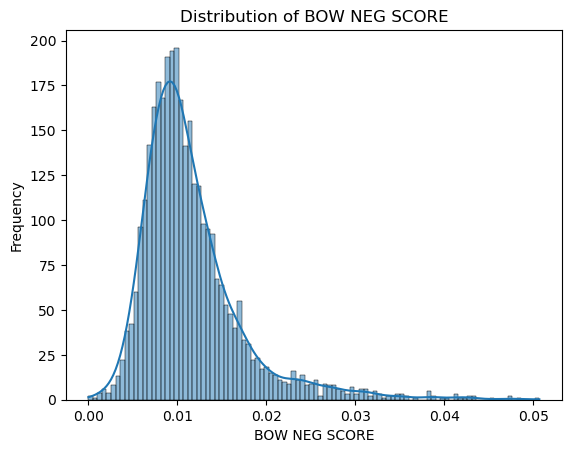

In [10]:
# The distribution of BOW Negative Scores
df_10ksp_filtered3.head(3)
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=df_10ksp_filtered3, x='neg_proportion', bins=100, kde=True)
plt.title('Distribution of BOW NEG SCORE')
plt.xlabel('BOW NEG SCORE')
plt.ylabel('Frequency')
plt.show()

#### 1.1 BOW VS ABNORMAL VOLUME

In [48]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

merged_df = pd.merge(df_10ksp_filtered3, vol, on='ACCESSION NUMBER')
merged_df = merged_df.dropna(subset=['abnormal_vol_mcd'])
# merged_df = merged_df[merged_df['abnormal_vol_mcd']>=1]

merged_df['PB_ratios'] = pd.to_numeric(merged_df['PB_ratios'], errors='coerce')
merged_df['PB_ratios'].fillna(merged_df['PB_ratios'].mean(), inplace=True)

merged_df['mkt_cap'] = pd.to_numeric(merged_df['mkt_cap'], errors='coerce')
merged_df['mkt_cap'].fillna(merged_df['mkt_cap'].mean(), inplace=True)


from sklearn.preprocessing import StandardScaler
import pandas as pd
import statsmodels.api as sm


X = merged_df[['Negative','Positive','Total Word Count', 'mkt_cap', 'PB_ratios']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_with_const = sm.add_constant(X_scaled)

Y = merged_df['abnormal_vol_mcd']

model = sm.OLS(Y, X_scaled_with_const).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       abnormal_vol_mcd   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.296
Date:                Sun, 25 Feb 2024   Prob (F-statistic):              0.263
Time:                        17:24:02   Log-Likelihood:                -2862.7
No. Observations:                3063   AIC:                             5737.
Df Residuals:                    3057   BIC:                             5774.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1500      0.011    103.201      0.0

#### 1.2 BOW VS ABNORMAL RETURN

In [52]:
#merge the abnormal return
merged_df = pd.merge(merged_df, ar[['ACCESSION NUMBER', 'CAR(T0)', 'CAR(T1)', 'CAR(T3)', 'CAR(T5)', 'CAR(T10)', 'CAR(T15)', 'CAR(T20)', 'CAR(T30)', 'CAR(T60)']], on='ACCESSION NUMBER', how='left')


In [68]:
X = merged_df[['Negative','Positive','Total Word Count','mkt_cap', 'PB_ratios']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_with_const = sm.add_constant(X_scaled)

Y = merged_df['CAR(T0)']

model = sm.OLS(Y, X_scaled_with_const).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                CAR(T0)   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7733
Date:                Sun, 25 Feb 2024   Prob (F-statistic):              0.569
Time:                        17:41:54   Log-Likelihood:                 6502.0
No. Observations:                3065   AIC:                        -1.299e+04
Df Residuals:                    3059   BIC:                        -1.296e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      1.111      0.2

## 2. TF-IDF

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


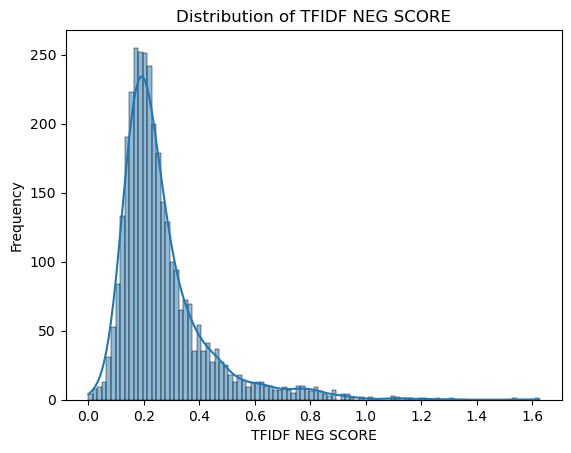

In [23]:
# The distribution of TF-IDF negative scores
sns.histplot(data=df_10ksp_filtered4, x='Negative_tf', bins=100, kde=True)
plt.title('Distribution of TFIDF NEG SCORE')
plt.xlabel('TFIDF NEG SCORE')
plt.ylabel('Frequency')
plt.show()

#### 2.1 TFIDF VS ABNORMAL VOLUME

In [24]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler


merge_tf = pd.merge(df_10ksp_filtered4, vol, on='ACCESSION NUMBER')
merge_tf = merge_tf.dropna(subset=['abnormal_vol_mcd'])
# merge_tf = merge_tf[merge_tf['abnormal_vol_mcd'] >= 1]


merge_tf['PB_ratios'] = pd.to_numeric(merge_tf['PB_ratios'], errors='coerce')
merge_tf['PB_ratios'].fillna(merge_tf['PB_ratios'].mean(), inplace=True)

merge_tf['mkt_cap'] = pd.to_numeric(merge_tf['mkt_cap'], errors='coerce')
merge_tf['mkt_cap'].fillna(merge_tf['mkt_cap'].mean(), inplace=True)

X = merge_tf[['Negative_tf', 'Positive_tf', 'mkt_cap', 'PB_ratios']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_with_const = sm.add_constant(X_scaled)


Y = merge_tf['abnormal_vol_mcd']

model = sm.OLS(Y, X_scaled_with_const).fit()

print(model.summary())



                            OLS Regression Results                            
Dep. Variable:       abnormal_vol_mcd   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.172
Date:                Sun, 25 Feb 2024   Prob (F-statistic):              0.321
Time:                        16:44:07   Log-Likelihood:                -2863.6
No. Observations:                3063   AIC:                             5737.
Df Residuals:                    3058   BIC:                             5767.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1500      0.011    103.187      0.0

## 3. FINBERT

/Applications/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


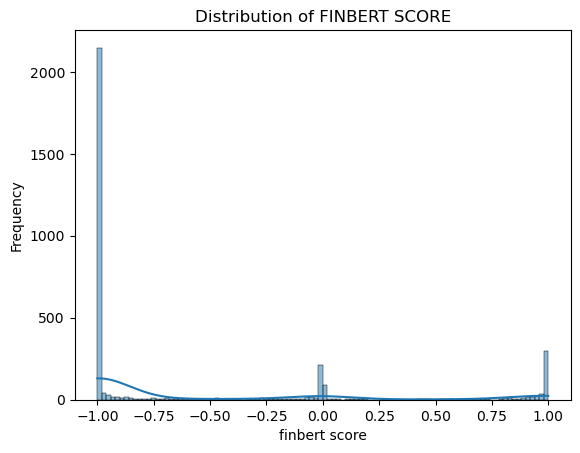

In [22]:
# The distribution of FINBERT  scores
sns.histplot(data=df_10ksp_filtered5, x='FINBERT SCORE', bins=100, kde=True)
plt.title('Distribution of FINBERT SCORE')
plt.xlabel('finbert score')
plt.ylabel('Frequency')
plt.show()

#### 3.1 FINBERT VS ABNORMAL VOLUME

In [25]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm


merged_df2 = pd.merge(df_10ksp_filtered5, vol, on='ACCESSION NUMBER')
merged_df2 = merged_df2.dropna(subset=['abnormal_vol_mcd'])


merged_df2['PB_ratios'] = pd.to_numeric(merged_df2['PB_ratios'], errors='coerce')
merged_df2['PB_ratios'].fillna(merged_df2['PB_ratios'].mean(), inplace=True)


merged_df2['mkt_cap'] = pd.to_numeric(merged_df2['mkt_cap'], errors='coerce')
merged_df2['mkt_cap'].fillna(merged_df2['mkt_cap'].mean(), inplace=True)


merged_df2['abnormal_vol_mcd'] = pd.to_numeric(merged_df2['abnormal_vol_mcd'], errors='coerce')

from sklearn.preprocessing import StandardScaler
import pandas as pd
import statsmodels.api as sm


X = merged_df2[['FINBERT SCORE', 'mkt_cap', 'PB_ratios']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_scaled_with_const = sm.add_constant(X_scaled)


Y = merged_df['abnormal_vol_mcd']


model = sm.OLS(Y, X_scaled_with_const).fit()

print(model.summary())
merged_df


                            OLS Regression Results                            
Dep. Variable:       abnormal_vol_mcd   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.493
Date:                Sun, 25 Feb 2024   Prob (F-statistic):              0.214
Time:                        16:45:55   Log-Likelihood:                -2863.7
No. Observations:                3063   AIC:                             5735.
Df Residuals:                    3059   BIC:                             5760.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1500      0.011    103.201      0.0

,Unnamed: 0_x,ACCESSION NUMBER,CONFORMED SUBMISSION TYPE,CONFORMED PERIOD OF REPORT,FILED AS OF DATE,DATE AS OF CHANGE,COMPANY CONFORMED NAME,CENTRAL INDEX KEY,FISCAL YEAR END,Item 7 Content,...,T5PP,T20PP,T60PP,d4,abnormal,Year,Unnamed: 0_y,mkt_cap,PB_ratios,abnormal_vol_mcd
2,9,0000898430-00-003950,10-K,20000930,20001227,Not found,JACOBS ENGINEERING GROUP INC /DE/,52988,0930,Item 7. - Management's Discussion and Analysis...,...,2.015832,-0.712067,-0.857550,85475.00,1.757851,2000,J US,1222.125877,2.460000,2.757851
3,10,0000060086-00-000011,10-K405,19991231,20000330,Not found,LOEWS CORP,60086,1231,"Item 7, Management's\nDiscussion and Analysis ...",...,-0.012115,1.207968,-0.280501,51475.00,-0.214361,2000,L US,10212.712211,0.910000,0.785639
13,48,0000943819-00-000018,10-K,20000630,20000925,Not found,RESMED INC,943819,0630,Item 7 MANAGEMENT'S DISCUSSION AND ANALYSIS OF...,...,0.655906,-0.465737,-0.316165,471925.00,1.053455,2000,RMD US,1235.447117,12.980000,2.053455
16,65,0000037996-01-000014,10-K,20001231,20010322,Not found,FORD MOTOR CO,37996,1231,Item 7. Management's Discussion and Analysis o...,...,0.103312,0.394406,0.170709,5646300.00,-0.001272,2001,F US,28466.976468,3.850000,0.998728
17,67,0000060086-01-500005,10-K405,20001231,20010316,Not found,LOEWS CORP,60086,1231,Item 7.\n\n Legislation and Regulation: Federa...,...,1.492483,0.060411,0.151379,211500.00,1.530358,2001,L US,10604.899031,1.120000,2.530358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3089,5016,0001628280-23-005434,10-K,20221231,20230228,20230228,LINDE PLC,1707925,1231,"Item 7, Management s Discussion and Analysis o...",...,0.480718,-0.231724,-0.145457,3129098.25,0.539820,2023,LIN US,199149.371505,5.010000,1.539820
3090,5018,0000950170-23-064855,10-K,20230930,20231117,20231117,WestRock Co,1732845,0930,Item 7. Management s Discussion and Analysis o...,...,0.106166,0.220531,NaN,3125557.50,0.041522,2023,WRK US,10650.201116,1.060000,1.041522
3091,5019,0001739940-23-000008,10-K,20221231,20230223,20230223,Cigna Group,1739940,1231,Item 7 of this Form 10-K for additional inform...,...,0.020097,0.331003,-0.058747,1514873.50,-0.063155,2023,CI US,87625.048819,1.890000,0.936845
3092,5020,0001748790-23-000030,10-K,20230630,20230817,20230817,Amcor plc,1748790,0630,Item 7. - Management's Discussion and Analysis...,...,-0.278783,0.352998,-0.148380,6248675.75,-0.167780,2023,AMCR US,13933.108564,3.470000,0.832220


### Preparation of the Makret responce data (abnormal return and volume)and financial report data (revenue and profit)

#### The data must be mapped at the dimension of Accession number

In [162]:
#Prepare the dim table
target_dim=df_10ksp_filtered3.iloc[:,0:8]
target_dim.reset_index(inplace=True,drop=True)



In [163]:
target_dim.to_csv('target_dim.csv')

### Quoting the data from market response observations and financial report
#### (1)revenue variance
#### (2)profit variance
#### (3)abnormal return
#### (4)abnormal volume
#### (5)market cap (control variable)
#### (6)P/B ratio (control variable)

In [164]:
# financial report data preparation (revenue and profit)
financials_url = 'https://raw.githubusercontent.com/ethancn01/10ksentimentalanalysis/main/financials.csv'
financials=pd.read_csv(financials_url)

In [165]:
metarevenue_url = 'https://raw.githubusercontent.com/ethancn01/10ksentimentalanalysis/main/metafinancials_revenue.xlsx'
metarevenue=pd.read_excel(metarevenue_url)
metaprofit_url = 'https://raw.githubusercontent.com/ethancn01/10ksentimentalanalysis/main/metafinancials_netincome.xlsx'
metaprofit=pd.read_excel(metaprofit_url)

In [166]:
# Rename revenue and net income and labelize with time
financials.rename(columns={'REVENUE': 'Y0_REV', 'INCOME': 'Y0_NI'}, inplace=True)


In [3]:
#volume data and control variables
vol_url='https://raw.githubusercontent.com/ethancn01/10ksentimentalanalysis/main/Vol_data.csv'
vol=pd.read_csv(vol_url)

In [4]:
vol.drop(vol.columns[-2], axis=1, inplace=True)
vol['abnormal_vol_mcd']=vol['d4']/vol['base_vol']
vol['abnormal_vol_mcd'].mean()

1.1499918794793276

In [16]:
df_10ksp_filtered3

,Unnamed: 0,ACCESSION NUMBER,CONFORMED SUBMISSION TYPE,CONFORMED PERIOD OF REPORT,FILED AS OF DATE,DATE AS OF CHANGE,COMPANY CONFORMED NAME,CENTRAL INDEX KEY,FISCAL YEAR END,Item 7 Content,...,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Item 7 Word Count,Item 7A Word Count,Total Word Count
0,1,0000004904-00-000039,10-K405,19991231,20000324,Not found,AMERICAN ELECTRIC POWER COMPANY INC,4904,1231,Item 7. MANAGEMENT'S DISCUSSION AND ANALYSIS O...,...,3,0,1,14,0,0,14,334,286,620
1,7,0000037996-00-000019,10-K,19991231,20000316,Not found,FORD MOTOR CO,37996,1231,Item 7. Management's Discussion and Analysis o...,...,53,47,81,10,12,11,10,4996,871,5867
2,9,0000898430-00-003950,10-K,20000930,20001227,Not found,JACOBS ENGINEERING GROUP INC /DE/,52988,0930,Item 7. - Management's Discussion and Analysis...,...,11,6,20,38,3,5,5,2205,11,2216
3,10,0000060086-00-000011,10-K405,19991231,20000330,Not found,LOEWS CORP,60086,1231,"Item 7, Management's\nDiscussion and Analysis ...",...,728,125,344,759,33,76,67,23753,1507,25260
4,12,0000912057-00-014257,10-K405,19991231,20000329,Not found,NORTHERN STATES POWER CO /MN/,72903,1231,Item 7. \n\nNSP\nand Dairyland Power Cooperati...,...,89,49,138,103,31,44,62,10158,20,10178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,5017,0000950170-23-005559,10-K,20221231,20230301,20230301,Ceridian HCM Holding Inc.,1725057,1231,Item 7. Management s Discussion and Analysis o...,...,63,55,92,38,18,19,48,9980,1036,11016
3330,5018,0000950170-23-064855,10-K,20230930,20231117,20231117,WestRock Co,1732845,0930,Item 7. Management s Discussion and Analysis o...,...,98,41,172,59,18,58,91,7773,2116,9889
3331,5019,0001739940-23-000008,10-K,20221231,20230223,20230223,Cigna Group,1739940,1231,Item 7 of this Form 10-K for additional inform...,...,311,116,304,196,35,134,108,18734,31,18765
3332,5020,0001748790-23-000030,10-K,20230630,20230817,20230817,Amcor plc,1748790,0630,Item 7. - Management's Discussion and Analysis...,...,139,39,129,45,13,36,69,8192,920,9112


In [27]:
df_10ksp_filtered3['neg_proportion']=df_10ksp_filtered3['Negative']/df_10ksp_filtered3['Total Word Count']
df_10ksp_filtered3['pos_proportion']=df_10ksp_filtered3['Positive']/df_10ksp_filtered3['Total Word Count']
df_10ksp_filtered3['unc_proportion']=df_10ksp_filtered3['Uncertainty']/df_10ksp_filtered3['Total Word Count']
df_10ksp_filtered3['lit_proportion']=df_10ksp_filtered3['Litigious']/df_10ksp_filtered3['Total Word Count']
df_10ksp_filtered3['str_proportion']=df_10ksp_filtered3['Strong_Modal']/df_10ksp_filtered3['Total Word Count']
df_10ksp_filtered3['wea_proportion']=df_10ksp_filtered3['Weak_Modal']/df_10ksp_filtered3['Total Word Count']
df_10ksp_filtered3['con_proportion']=df_10ksp_filtered3['Constraining']/df_10ksp_filtered3['Total Word Count']

In [31]:
df_prop=df_10ksp_filtered3[['neg_proportion','pos_proportion','unc_proportion','lit_proportion','str_proportion','wea_proportion','con_proportion']]
df_prop.describe()

,neg_proportion,pos_proportion,unc_proportion,lit_proportion,str_proportion,wea_proportion,con_proportion
count,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000,3334.000000
mean,0.011571,0.006225,0.013852,0.005619,0.001949,0.004426,0.005663
std,0.005823,0.002186,0.005473,0.003645,0.001005,0.003511,0.002197
min,0.000000,0.000000,0.000701,0.000000,0.000000,0.000000,0.000000
25%,0.007938,0.004772,0.010474,0.003243,0.001298,0.002625,0.004378
50%,0.010209,0.005923,0.012921,0.004825,0.001807,0.003429,0.005426
75%,0.013510,0.007446,0.015742,0.006854,0.002398,0.004781,0.006654
max,0.050673,0.019985,0.060901,0.036677,0.012680,0.031815,0.023443


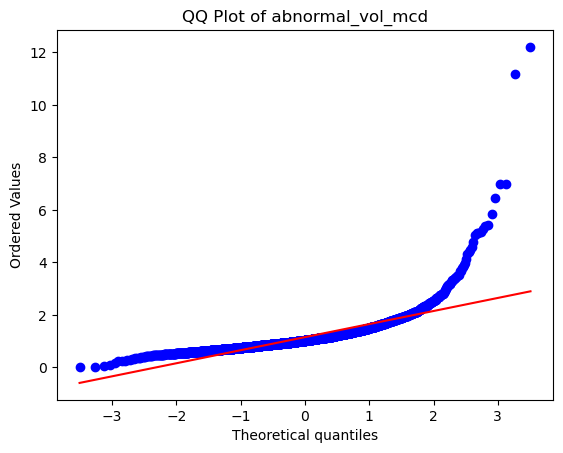

In [18]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# 假设 merged_df 是您已经有的DataFrame，并且它包含 'abnormal_vol_mcd' 这一列

# 绘制QQ图
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(merged_df['abnormal_vol_mcd'], dist="norm", plot=ax)
ax.set_title("QQ Plot of abnormal_vol_mcd")

plt.show()


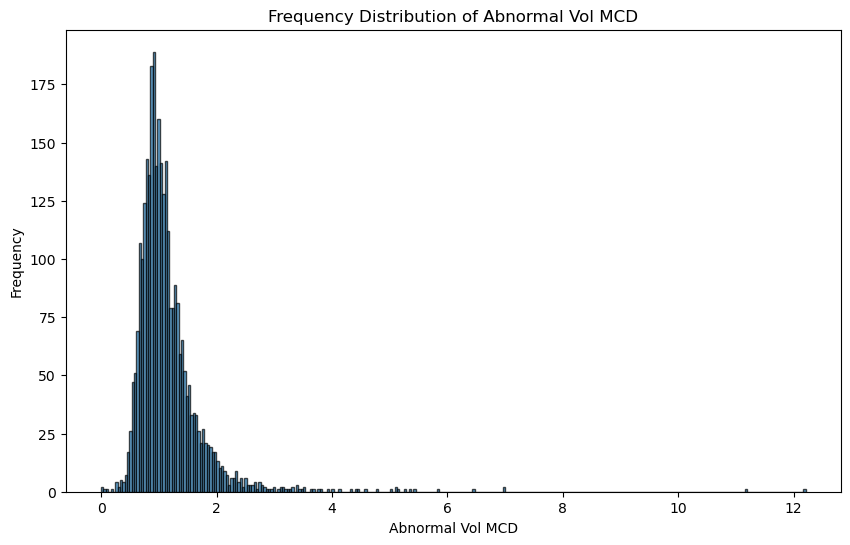

In [25]:
import matplotlib.pyplot as plt

# 假设 merged_df 是您的 DataFrame，并且它包含一个名为 'abnormal_vol_mcd' 的列
# 下面的代码将绘制 'abnormal_vol_mcd' 的频率分布图

# 设置图形的尺寸
plt.figure(figsize=(10, 6))

# 绘制直方图，您可以调整 bins 的数量来改变条形的精细度
plt.hist(merged_df['abnormal_vol_mcd'], bins=300, alpha=0.7, edgecolor='black')

# 添加图形的标题和坐标轴标签
plt.title('Frequency Distribution of Abnormal Vol MCD')
plt.xlabel('Abnormal Vol MCD')
plt.ylabel('Frequency')

# 显示图形
plt.show()


In [261]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# 假设 merged_df 是已经准备好的DataFrame，其中包含了所需的所有变量

# 清理数据：删除包含NaN或inf的样本
merged_df_cleaned = merged_df.dropna(subset=['abnormal_vol_mcd', 'Negative', 'Positive', 'Total Word Count', 'mkt_cap', 'PB_ratios'])
merged_df_cleaned = merged_df_cleaned[~merged_df_cleaned[['abnormal_vol_mcd', 'Negative', 'Positive', 'Total Word Count', 'mkt_cap', 'PB_ratios']].isin([np.inf, -np.inf]).any(axis=1)]

# 定义函数进行假设检验
def hypothesis_test(variable, data):
    # 删除变量为NaN或inf的样本
    data_filtered = data[~data[variable].isin([np.nan, np.inf, -np.inf])]
    
    # 计算Pearson相关系数和p值
    correlation, p_value = pearsonr(data_filtered[variable], data_filtered['abnormal_vol_mcd'])
    
    # 输出结果
    print(f"与 '{variable}' 的 Pearson 相关系数为: {correlation}")
    print(f"对应的p值为: {p_value}")
    if p_value < 0.05:
        print(f"在显著性水平为0.05下，拒绝原假设，表明'{variable}'与'abnormal_vol_mcd'之间存在显著相关性。")
    else:
        print(f"在显著性水平为0.05下，接受原假设，表明'{variable}'与'abnormal_vol_mcd'之间不存在显著相关性。")

# 对'Negative', 'Positive', 'Total Word Count', 'mkt_cap', 'PB_ratios'进行假设检验
variables_to_test = ['Negative', 'Positive', 'Total Word Count', 'mkt_cap', 'PB_ratios']
for variable in variables_to_test:
    hypothesis_test(variable, merged_df_cleaned)


与 'Negative' 的 Pearson 相关系数为: 0.015414196135659052
对应的p值为: 0.39377492459832747
在显著性水平为0.05下，接受原假设，表明'Negative'与'abnormal_vol_mcd'之间不存在显著相关性。
与 'Positive' 的 Pearson 相关系数为: -0.0126679001432628
对应的p值为: 0.4834035063840094
在显著性水平为0.05下，接受原假设，表明'Positive'与'abnormal_vol_mcd'之间不存在显著相关性。
与 'Total Word Count' 的 Pearson 相关系数为: -0.0012483818768238223
对应的p值为: 0.9449396774974069
在显著性水平为0.05下，接受原假设，表明'Total Word Count'与'abnormal_vol_mcd'之间不存在显著相关性。
与 'mkt_cap' 的 Pearson 相关系数为: -0.0012518138506721315
对应的p值为: 0.9447885504609083
在显著性水平为0.05下，接受原假设，表明'mkt_cap'与'abnormal_vol_mcd'之间不存在显著相关性。
与 'PB_ratios' 的 Pearson 相关系数为: 0.018783140722042506
对应的p值为: 0.29870774604680844
在显著性水平为0.05下，接受原假设，表明'PB_ratios'与'abnormal_vol_mcd'之间不存在显著相关性。


In [197]:
print(df_10ksp_filtered3)

      Unnamed: 0      ACCESSION NUMBER CONFORMED SUBMISSION TYPE  \
0              7  0000004904-00-000039                   10-K405   
1             60  0000037996-00-000019                      10-K   
2             83  0000898430-00-003950                      10-K   
3             89  0000060086-00-000011                   10-K405   
4            107  0000912057-00-014257                   10-K405   
...          ...                   ...                       ...   
3351       11006  0000950170-23-005559                      10-K   
3352       11009  0000950170-23-064855                      10-K   
3353       11010  0001739940-23-000008                      10-K   
3354       11013  0001748790-23-000030                      10-K   
3355       11022  0001784031-23-000007                      10-K   

      CONFORMED PERIOD OF REPORT  FILED AS OF DATE DATE AS OF CHANGE  \
0                       19991231          20000324         Not found   
1                       19991231       

In [200]:
%store -r financials

no stored variable or alias financials


In [209]:
financialsmd_url = 'https://raw.githubusercontent.com/ethancn01/10ksentimentalanalysis/main/financials_md.csv'
financials_md=pd.read_csv(financialsmd_url)

In [214]:
import pandas as pd
from scipy.stats import pearsonr

financials_md_filtered = financials_md[~financials_md['Unnamed: 0'].isin([np.nan, np.inf, -np.inf])]
# 合并两个数据框基于ACCESSION NUMBER
merged_df = pd.merge(financials_md_filtered, df_10ksp_filtered3, on='ACCESSION NUMBER', how='inner')

# 删除因变量为NaN或inf的样本
merged_df = merged_df[~merged_df['neg_proportion'].isin([np.nan, np.inf, -np.inf])]

# 定义函数进行假设检验
def hypothesis_test(variable, data):
    # 删除变量为NaN或inf的样本
    data_filtered = data[~data[variable].isin([np.nan, np.inf, -np.inf])]
    
    # 计算Pearson相关系数和p值
    correlation, p_value = pearsonr(data_filtered['neg_proportion'], data_filtered[variable])
    
    # 输出结果
    print(f"与 {variable} 的 Pearson 相关系数为: {correlation}")
    print(f"对应的p值为: {p_value}")
    if p_value < 0.05:
        print("在显著性水平为0.05下，拒绝原假设，表明两个变量之间存在显著相关性。")
    else:
        print("在显著性水平为0.05下，接受原假设，表明两个变量之间不存在显著相关性。")

# 进行假设检验
hypothesis_test('CURRENT REVENUE YOY', merged_df)
hypothesis_test('NEXT REVENUE YOY', merged_df)
hypothesis_test('CURRENT PROFIT MARGIN YOY', merged_df)
hypothesis_test('NEXT PROFIT MARGIN YOY', merged_df)



与 CURRENT REVENUE YOY 的 Pearson 相关系数为: -0.03402224039418022
对应的p值为: 0.09205138528549471
在显著性水平为0.05下，接受原假设，表明两个变量之间不存在显著相关性。
与 NEXT REVENUE YOY 的 Pearson 相关系数为: -0.04310307407255115
对应的p值为: 0.024314368880352658
在显著性水平为0.05下，拒绝原假设，表明两个变量之间存在显著相关性。
与 CURRENT PROFIT MARGIN YOY 的 Pearson 相关系数为: -0.020593873960571347
对应的p值为: 0.3079386580894225
在显著性水平为0.05下，接受原假设，表明两个变量之间不存在显著相关性。
与 NEXT PROFIT MARGIN YOY 的 Pearson 相关系数为: -0.005769968677075393
对应的p值为: 0.77538455044592
在显著性水平为0.05下，接受原假设，表明两个变量之间不存在显著相关性。


In [260]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

# 假设 df_10ksp_filtered3 和 vol 是已经准备好的DataFrame
# 直接使用 'ACCESSION NUMBER' 进行合并
merged_df = pd.merge(df_10ksp_filtered3, vol, on='ACCESSION NUMBER')
# 对 'PB_ratios' 进行数值类型转换并处理缺失值
merged_df['PB_ratios'] = pd.to_numeric(merged_df['PB_ratios'], errors='coerce')
pb_ratios_mean = merged_df['PB_ratios'].mean()  # 先计算平均值
merged_df['PB_ratios'].fillna(pb_ratios_mean, inplace=True)

# 对 'mkt_cap' 进行数值类型转换并处理缺失值
merged_df['mkt_cap'] = pd.to_numeric(merged_df['mkt_cap'], errors='coerce')
mkt_cap_mean = merged_df['mkt_cap'].mean()  # 先计算平均值
merged_df['mkt_cap'].fillna(mkt_cap_mean, inplace=True)

# 选择解释变量并进行标准化
X = merged_df[['neg_proportion', 'mkt_cap', 'PB_ratios']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 添加常数项用于截距
X_scaled_with_const = sm.add_constant(X_scaled)

# 指定因变量
Y = merged_df['T0P']

# 拟合模型
model = sm.OLS(Y, X_scaled_with_const).fit()

# 打印统计结果
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    T0P   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.359
Date:                Sun, 25 Feb 2024   Prob (F-statistic):              0.253
Time:                        13:44:37   Log-Likelihood:                -13773.
No. Observations:                3094   AIC:                         2.755e+04
Df Residuals:                    3090   BIC:                         2.758e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.8980      0.373     34.554      0.0

### FINBERT

In [8]:
import ast

def get_sentiment(sentiment_results):
    n = sentiment_results.shape[0]

    result  = pd.DataFrame({
    'negative': [0] * n,
    'neutral': [0] * n,
    'positive': [0] * n,
    'sentiment_value': [0] * n
    })

    for i in range(0,n):
        s = ast.literal_eval(sentiment_results[i])
        for j in range(0,3):
            result[s[j][0]][i]=s[j][1]
    result['sentiment_value'] = 1*result['positive'] + 0*result['neutral'] - 1*result['negative']
    return result
result = get_sentiment(df_10ksp_filtered5 ['sentiment_results'])

# Reset index if necessary to ensure it's unique and sequential
df1 = df_10ksp_filtered5.reset_index(drop=True)
df2 = result.reset_index(drop=True)

# Create an artificial key
df1['key'] = df1.index
df2['key'] = df2.index

# Merge on the artificial key
df_10ksp_filtered5  = pd.merge(df1, df2, on='key')

# Optionally, you can drop the artificial key after merging
df_10ksp_filtered5  = df_10ksp_filtered5 .drop('key', axis=1)

/var/folders/nr/053gf3x97yg912g1cs827wrw0000gn/T/ipykernel_73856/800945944.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.99999857' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result[s[j][0]][i]=s[j][1]
/var/folders/nr/053gf3x97yg912g1cs827wrw0000gn/T/ipykernel_73856/800945944.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result[s[j][0]][i]=s[j][1]
/var/folders/nr/053gf3x97yg912g1cs827wrw0000gn/T/ipykernel_73856/800945944.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '7.7456053e-07' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  result[s[j][0]][i]=s[j][1]

In [11]:
df_10ksp_filtered5.head(5)

,Unnamed: 0,ACCESSION NUMBER,CONFORMED SUBMISSION TYPE,CONFORMED PERIOD OF REPORT,FILED AS OF DATE,DATE AS OF CHANGE,COMPANY CONFORMED NAME,CENTRAL INDEX KEY,FISCAL YEAR END,Item 7 Content,...,Item 7 Word Count,Item 7A Word Count,Total Word Count,combined_content,sentiment_results,FINBERT SCORE,negative,neutral,positive,sentiment_value
0,1,0000004904-00-000039,10-K405,19991231,20000324,Not found,AMERICAN ELECTRIC POWER COMPANY INC,4904,1231,Item 7. MANAGEMENT'S DISCUSSION AND ANALYSIS O...,...,334,286,620,Item 7. MANAGEMENT'S DISCUSSION AND ANALYSIS O...,"[('negative', 0.99999857), ('neutral', 7.74560...",-0.999998,0.999999,7.745605e-07,7.355076e-07,-0.999998
1,7,0000037996-00-000019,10-K,19991231,20000316,Not found,FORD MOTOR CO,37996,1231,Item 7. Management's Discussion and Analysis o...,...,4996,871,5867,Item 7. Management's Discussion and Analysis o...,"[('negative', 0.999931), ('neutral', 6.152944e...",-0.999923,0.999931,6.152944e-05,7.506078e-06,-0.999923
2,9,0000898430-00-003950,10-K,20000930,20001227,Not found,JACOBS ENGINEERING GROUP INC /DE/,52988,0930,Item 7. - Management's Discussion and Analysis...,...,2205,11,2216,Item 7. - Management's Discussion and Analysis...,"[('negative', 0.9999988), ('positive', 6.69888...",-0.999998,0.999999,4.883081e-07,6.698880e-07,-0.999998
3,10,0000060086-00-000011,10-K405,19991231,20000330,Not found,LOEWS CORP,60086,1231,"Item 7, Management's\nDiscussion and Analysis ...",...,23753,1507,25260,"Item 7, Management's\nDiscussion and Analysis ...","[('negative', 0.7863398), ('neutral', 0.213465...",-0.786145,0.786340,2.134655e-01,1.947179e-04,-0.786145
4,12,0000912057-00-014257,10-K405,19991231,20000329,Not found,NORTHERN STATES POWER CO /MN/,72903,1231,Item 7. \n\nNSP\nand Dairyland Power Cooperati...,...,10158,20,10178,Item 7. \n\nNSP\nand Dairyland Power Cooperati...,"[('negative', 0.9999467), ('neutral', 4.968502...",-0.999943,0.999947,4.968502e-05,3.612313e-06,-0.999943


In [13]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

# 假设 df_10ksp_filtered5 和 vol 是已经准备好的DataFrame
# 直接使用 'ACCESSION NUMBER' 进行合并
merged_df2 = pd.merge(df_10ksp_filtered5, vol, on='ACCESSION NUMBER')
merged_df2 = merged_df2.dropna(subset=['abnormal_vol_mcd'])

# 将 'PB_ratios' 转换为数值类型，对于无法转换的值强制转换为 NaN，并填充缺失值
merged_df2['PB_ratios'] = pd.to_numeric(merged_df2['PB_ratios'], errors='coerce')
merged_df2['PB_ratios'].fillna(merged_df2['PB_ratios'].mean(), inplace=True)

# 确保 'mkt_cap' 也是数值类型，并处理任何缺失值
merged_df2['mkt_cap'] = pd.to_numeric(merged_df2['mkt_cap'], errors='coerce')
merged_df2['mkt_cap'].fillna(merged_df2['mkt_cap'].mean(), inplace=True)

# 确保 'neg_proportion' 和 'T0P' 是数值类型（它们应该已经是，但为了安全起见再次确认）
merged_df2['abnormal_vol_mcd'] = pd.to_numeric(merged_df2['abnormal_vol_mcd'], errors='coerce')

from sklearn.preprocessing import StandardScaler
import pandas as pd
import statsmodels.api as sm

# 假设 merged_df 是合并后的DataFrame

# 选择解释变量并进行标准化
X = merged_df2[['FINBERT SCORE', 'mkt_cap', 'PB_ratios']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 添加常数项用于截距
X_scaled_with_const = sm.add_constant(X_scaled)

# 指定因变量
Y = merged_df['abnormal_vol_mcd']

# 拟合模型
model = sm.OLS(Y, X_scaled_with_const).fit()

# 打印统计结果
print(model.summary())
merged_df


                            OLS Regression Results                            
Dep. Variable:       abnormal_vol_mcd   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.493
Date:                Sun, 25 Feb 2024   Prob (F-statistic):              0.214
Time:                        14:29:31   Log-Likelihood:                -2863.7
No. Observations:                3063   AIC:                             5735.
Df Residuals:                    3059   BIC:                             5760.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1500      0.011    103.201      0.0

,Unnamed: 0_x,ACCESSION NUMBER,CONFORMED SUBMISSION TYPE,CONFORMED PERIOD OF REPORT,FILED AS OF DATE,DATE AS OF CHANGE,COMPANY CONFORMED NAME,CENTRAL INDEX KEY,FISCAL YEAR END,Item 7 Content,...,T5PP,T20PP,T60PP,d4,abnormal,Year,Unnamed: 0_y,mkt_cap,PB_ratios,abnormal_vol_mcd
2,9,0000898430-00-003950,10-K,20000930,20001227,Not found,JACOBS ENGINEERING GROUP INC /DE/,52988,0930,Item 7. - Management's Discussion and Analysis...,...,2.015832,-0.712067,-0.857550,85475.00,1.757851,2000,J US,1222.125877,2.460000,2.757851
3,10,0000060086-00-000011,10-K405,19991231,20000330,Not found,LOEWS CORP,60086,1231,"Item 7, Management's\nDiscussion and Analysis ...",...,-0.012115,1.207968,-0.280501,51475.00,-0.214361,2000,L US,10212.712211,0.910000,0.785639
13,48,0000943819-00-000018,10-K,20000630,20000925,Not found,RESMED INC,943819,0630,Item 7 MANAGEMENT'S DISCUSSION AND ANALYSIS OF...,...,0.655906,-0.465737,-0.316165,471925.00,1.053455,2000,RMD US,1235.447117,12.980000,2.053455
16,65,0000037996-01-000014,10-K,20001231,20010322,Not found,FORD MOTOR CO,37996,1231,Item 7. Management's Discussion and Analysis o...,...,0.103312,0.394406,0.170709,5646300.00,-0.001272,2001,F US,28466.976468,3.850000,0.998728
17,67,0000060086-01-500005,10-K405,20001231,20010316,Not found,LOEWS CORP,60086,1231,Item 7.\n\n Legislation and Regulation: Federa...,...,1.492483,0.060411,0.151379,211500.00,1.530358,2001,L US,10604.899031,1.120000,2.530358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3089,5016,0001628280-23-005434,10-K,20221231,20230228,20230228,LINDE PLC,1707925,1231,"Item 7, Management s Discussion and Analysis o...",...,0.480718,-0.231724,-0.145457,3129098.25,0.539820,2023,LIN US,199149.371505,5.010000,1.539820
3090,5018,0000950170-23-064855,10-K,20230930,20231117,20231117,WestRock Co,1732845,0930,Item 7. Management s Discussion and Analysis o...,...,0.106166,0.220531,NaN,3125557.50,0.041522,2023,WRK US,10650.201116,1.060000,1.041522
3091,5019,0001739940-23-000008,10-K,20221231,20230223,20230223,Cigna Group,1739940,1231,Item 7 of this Form 10-K for additional inform...,...,0.020097,0.331003,-0.058747,1514873.50,-0.063155,2023,CI US,87625.048819,1.890000,0.936845
3092,5020,0001748790-23-000030,10-K,20230630,20230817,20230817,Amcor plc,1748790,0630,Item 7. - Management's Discussion and Analysis...,...,-0.278783,0.352998,-0.148380,6248675.75,-0.167780,2023,AMCR US,13933.108564,3.470000,0.832220


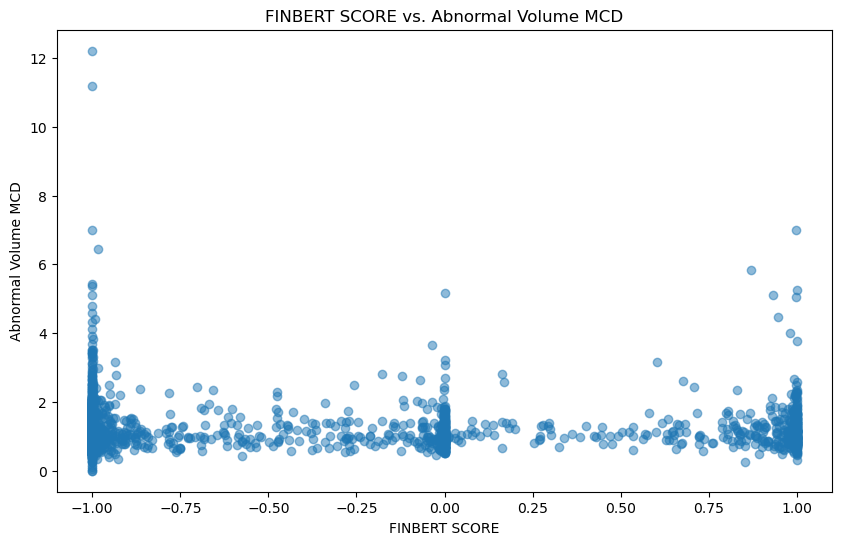

In [14]:
import matplotlib.pyplot as plt

# 假设 merged_df2 是您已经处理并准备好的 DataFrame
# 并且它包含 'FINBERT SCORE' 和 'abnormal_vol_mcd' 这两列

# 使用 matplotlib 生成散点图
plt.figure(figsize=(10, 6))  # 设置图形的尺寸
plt.scatter(merged_df2['FINBERT SCORE'], merged_df2['abnormal_vol_mcd'], alpha=0.5)  # alpha 参数控制点的透明度

# 添加图形的标题和坐标轴标签
plt.title('FINBERT SCORE vs. Abnormal Volume MCD')
plt.xlabel('FINBERT SCORE')
plt.ylabel('Abnormal Volume MCD')

# 显示图形
plt.show()
